# Seção 14 - Regressão Linear Simples
Para esta seção, usarei a base de dados plano_saude.csv do curso mesmo.

In [8]:
# Instruções basiconas de sempre.

# Lidar com dataframes.
import numpy as np
import pandas as pd

# Lidar com gráficos.
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from plotting import (multiple_histograms_plot,
                      bar_plot_with_categorical,
                      plot_confusion_matrix,
                      plot_confusion_matrix_2,
                      plot_roc)

# Lidar com preparação de dados.
from data_prep import data_prep as dp # Eu que fiz esse modulinho ("uuuuuuuuuma bosta!").
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Lidar com validação de modelos.
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

In [9]:
nomeDaBase = "../bases/plano_saude.csv"
df = pd.read_csv(nomeDaBase, sep=",", encoding="utf-8")

In [10]:
df.sample(5).T

,0,7,4,8,2
idade,18,53,38,58,28
custo,871,2454,1488,3066,1242


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
idade    10 non-null int64
custo    10 non-null int64
dtypes: int64(2)
memory usage: 240.0 bytes


In [12]:
df.describe()

,idade,custo
count,10.000000,10.000000
mean,40.500000,1946.700000
std,15.138252,1006.071353
min,18.000000,871.000000
25%,29.250000,1270.500000
50%,40.500000,1563.000000
75%,51.750000,2373.000000
max,63.000000,4090.000000


### Breve análise da  base:
Não foram encontrados problemas na base:

- não há nulos;
- não há valores que apresentam incosistências (ex.: negativos quando não é possível).

In [13]:
# Separando os fatores/previsores da resposta/target:
    
x = df.iloc[:, 0].values.reshape(-1,1)
y = df.iloc[:, 1].values.reshape(-1,1)

# IMPORTANTE! Tive que fazer um reshape nos valores de x e y.

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [15]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()

regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

In [16]:
print("Intercepto = {}".format(regressor.intercept_))
print("Coeficiente = {}".format(regressor.coef_))

Intercepto = [-710.11896552]
Coeficiente = [[64.66034483]]


### Visualisando:

In [17]:
reta_x = np.linspace(min(x)-5, max(x)+5,100).reshape(-1,1)
reta_y = regressor.predict(reta_x)
reta_df = np.concatenate((reta_x, reta_y), axis=1)
reta_df = pd.DataFrame(reta_df, columns=("x_idade", "y_custo"))

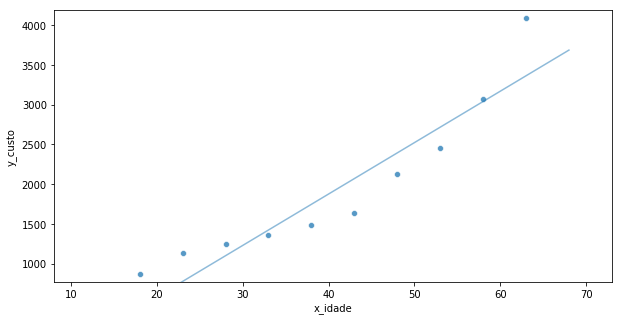

In [18]:
dimensoes = (10,5)
fig, ax = plt.subplots(figsize=dimensoes)
ax.set(xlim = (min(x)-10, max(x)+10),ylim=(min(y)-100, max(y)+100))
ax = sns.scatterplot(x="idade", y="custo", data=df, alpha=0.75);
ax = sns.lineplot(x="x_idade", y="y_custo", data=reta_df, alpha=0.5, palette="husl");

### Verificando o como o modelo se saiu

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("RMSE: {:.5}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("MAE: {:.5}".format(mean_absolute_error(y_test, y_pred)))
# print("MAPE:, ", mean_absolute_percentage_error(y_test, y_pred))
print("R2: {:.5}".format(r2_score(y_test, y_pred)))

################################################################################
# Cálculo do R2 ajustado:
def r2_ajustado(x_train, y_test, y_pred):
    """
    r2_ajustado retorna o R² Ajustado e recebe como argumento as séries com o
    valor alvo teste e o predito.
    """
    n = x_train.shape[0]
    k = x_train.shape[1]
    return (1-((n-1)/(n-(k+1)))*(1-r2_score(y_test, y_pred)))
################################################################################

print("R2 Ajustado: {:.5}".format(r2_ajustado(x_train, y_test, y_pred)))
print("MSE: {:.5}".format(mean_squared_error(y_test, y_pred)))

RMSE: 251.64
MAE: 190.37
R2: 0.93228
R2 Ajustado: 0.921
MSE: 6.3321e+04


### Erro Quadrático
Erro quadrático penalisa exponencialmente mais os erros. Assim, erros grande são muito piores que erros pequenos. Uma desvantágem é que a escala do erro quadrático é o quadrado da escala do target, fazendo com que a interpretação seja difícil.

### Erro Absoluto
O erro absoluto é na mesma escala do target, tendo interpretação fácil. Ele pondera linearmente erros maiores e por isso é mais robusto a outliers.

### Raíz Quadrada do Erro Quadrático
Mesmas vantagens e desvantagens do erro quadrático com a vantágem adicional de ser mais fácil de interpretar. A escolha entre esse erro e o erro absoluto vai do quanto você quer penalizar erros maiores. 

![img](https://matheusfacure.github.io/img/tutorial/cost-median-mean.png)

### $R^2$
O $R^2$ é uma métrica entre zero e um e é fácilmente interpretável como a explicação da variância do target pelo modelo. O $R^2$ também nos dá quão melhor estamos a partir da média (benchmark inicial). Porém, não é fácil saber a magnitude dos erros só pelo $R^2$.

Tutorial Completo em
https://matheusfacure.github.io/2017/03/03/func-custo-regr/

### Agora, usando validação cruzada.

In [20]:
resultados = cross_val_score(regressor, x, y, cv = 2)

print("Acurácia média: {:.3} ± {:.3}.".format(resultados.mean(), resultados.std()))

Acurácia média: -28.3 ± 28.0.
